<a href="https://colab.research.google.com/github/Jordan-mackey/python_projects/blob/main/LSTM_unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# For timeseries RNN LSTM neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [ ]:
# Import Keras: timeseries generator
# This class produces time series batches used on training/testing model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# import MinMaxScaler
# This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

# Dataset: FRED Unemployment Rates (01/01/1948 - 01/01/2022)

In [ ]:
dataset = 'DATA/unemployment.csv'

## Load Dataset into DataFrame

In [ ]:
df_all = pd.read_csv(dataset)

In [ ]:
df_all.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


## Keep Only the UNRATE Column for Unemployment Rate, Filter out DATE as Column

In [ ]:
df = df_all.iloc[ : , 1:2]

## EDA

In [ ]:
df.shape

(889, 1)

In [ ]:
df.dtypes

UNRATE    float64
dtype: object

In [ ]:
df.describe()

,UNRATE
count,889.000000
mean,5.758943
std,1.697299
min,2.500000
25%,4.500000
50%,5.600000
75%,6.800000
max,14.700000


In [ ]:
df.head()

,UNRATE
0,3.4
1,3.8
2,4.0
3,3.9
4,3.5


<AxesSubplot:>

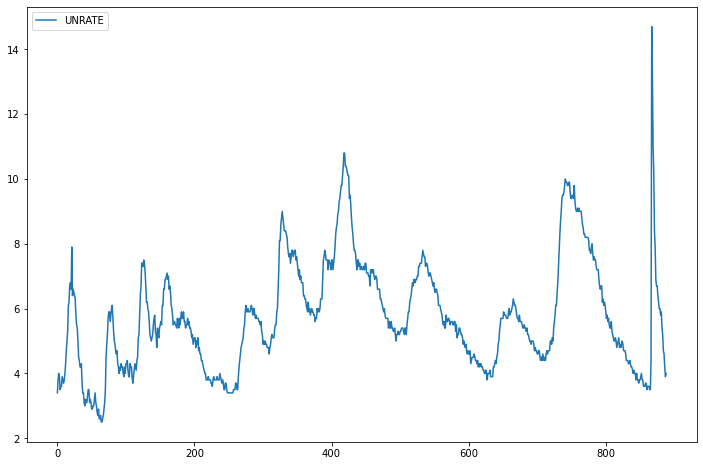

In [ ]:
df.plot(figsize = (12,8))

# Length of Input Timeseries - Number of Input Time Steps

In [ ]:
# Editing length of time steps to 36 (3 years time) to ideally improve accuracy
length36 = 36

# Timeseries Dataset: Train/Test Split

In [ ]:
len(df)

889

In [ ]:
# Set percentage of data used for testing
# Keeping the training dataset large (90%) to keep training points high
test_percent = 0.1

In [ ]:
# Number of data points reserved for testing the model
# 10% of the original dataset

len(df)*test_percent

88.9

## Split Data into Train/Test Datasets

In [ ]:
# Need to find the length of the testing dataset
# It has been found above that around 89 data points are used for testing

test_length = np.round(len(df)*test_percent)

test_length

89.0

In [ ]:
# Find the index of the sequence where the testing data starts
# test_start_index = int(len(df) - test_length)
split_index = int(len(df) - test_length)
split_index 

800

In [ ]:
# Create separate training and testing datasets 

# Training dataset: all indices from start to split_index
# excluding the split_index
data_train = df.iloc[ :split_index]

# Testing dataset: 
# --) all indices from (split_index - length24) to the end of the index
# --) split_index - length24: need the last 24 historical data points (also belong to data_train)
#     to predict the first data point of the data_test index
data_test = df.iloc[split_index - length36: ]

In [ ]:
data_train.head()

,UNRATE
0,3.4
1,3.8
2,4.0
3,3.9
4,3.5


In [ ]:
data_train.tail()

,UNRATE
795,6.2
796,6.3
797,6.1
798,6.2
799,6.1


In [ ]:
data_test.head()

,UNRATE
764,9.0
765,8.8
766,8.6
767,8.5
768,8.3


In [ ]:
data_test.tail()

,UNRATE
884,4.7
885,4.6
886,4.2
887,3.9
888,4.0


## Normalize the Data (Scaled to Range [0, 1])

In [ ]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [ ]:
# Only scale the training data, not the testing data
# Train the scaler to perform the normalization

scaler.fit(data_train)

MinMaxScaler()

In [ ]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normalize the testing dataset 
normalized_test = scaler.transform(data_test)

## Create TimeseriesGenerator for Training

In [ ]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Now using length36

# batch_size = the number of time series samples in each batch 
# Sample: a single time series input that has 36 historical datapoints
# Changed the batch_size to 15 to take in more samples
batch_size15 = 15

# Create a TimeseriesGenerator for training: train_tsGenerator
# --) This time series generator produces time series batches used to train the model
# TimeseriesGenerator(inputs, outputs, length, batch_size)
# --) normally, inputs & outputs are the same dataset during training and testing/validation

train_tsGenerator36 = TimeseriesGenerator(normalized_train, normalized_train, length = length36, batch_size = batch_size15)

In [ ]:
len(normalized_train)

800

In [ ]:
len(normalized_test)

125

In [ ]:
# What does the first batch look like?
X,y = train_tsGenerator36[0]

In [ ]:
print(X)

[[[0.10843373]
  [0.15662651]
  [0.18072289]
  [0.1686747 ]
  [0.12048193]
  [0.13253012]
  [0.13253012]
  [0.1686747 ]
  [0.15662651]
  [0.14457831]
  [0.15662651]
  [0.18072289]
  [0.21686747]
  [0.26506024]
  [0.30120482]
  [0.3373494 ]
  [0.43373494]
  [0.44578313]
  [0.5060241 ]
  [0.51807229]
  [0.4939759 ]
  [0.65060241]
  [0.46987952]
  [0.4939759 ]
  [0.48192771]
  [0.46987952]
  [0.45783133]
  [0.39759036]
  [0.36144578]
  [0.34939759]
  [0.30120482]
  [0.24096386]
  [0.22891566]
  [0.20481928]
  [0.20481928]
  [0.21686747]]

 [[0.15662651]
  [0.18072289]
  [0.1686747 ]
  [0.12048193]
  [0.13253012]
  [0.13253012]
  [0.1686747 ]
  [0.15662651]
  [0.14457831]
  [0.15662651]
  [0.18072289]
  [0.21686747]
  [0.26506024]
  [0.30120482]
  [0.3373494 ]
  [0.43373494]
  [0.44578313]
  [0.5060241 ]
  [0.51807229]
  [0.4939759 ]
  [0.65060241]
  [0.46987952]
  [0.4939759 ]
  [0.48192771]
  [0.46987952]
  [0.45783133]
  [0.39759036]
  [0.36144578]
  [0.34939759]
  [0.30120482]
  [0.240

In [ ]:
print(y)

[[0.14457831]
 [0.10843373]
 [0.10843373]
 [0.07228916]
 [0.06024096]
 [0.08433735]
 [0.07228916]
 [0.07228916]
 [0.09638554]
 [0.12048193]
 [0.12048193]
 [0.07228916]
 [0.08433735]
 [0.07228916]
 [0.04819277]]


# Build/Train/Test the Model

## Build the LSTM Model

In [ ]:
# Still only using the one feature: unemployment rate

n_features = 1

In [ ]:
# Define the model
model = Sequential()

# Add an LSTM layer
# 36 LSTM cells
# Activation function: relu
# Must return_sequences = True
# Changed the number of LSTM cells to 36, and increased Dropout rate to 0.2
model.add(LSTM(36, activation = 'relu', return_sequences = True, input_shape = (length36, n_features)))

# Dropout Layer 
model.add(Dropout(0.2))

# Add 2nd LSTM layer
model.add(LSTM(36, activation = 'relu', return_sequences = True))

# Dropout Layer
model.add(Dropout(0.2))

# 3rd LSTM layer
model.add(LSTM(36, activation = 'relu'))

# Add a FC layer 
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Compile the Model

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 36)            5472      
_________________________________________________________________
dropout (Dropout)            (None, 36, 36)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 36, 36)            10512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 36)                10512     
_________________________________________________________________
dense (Dense)                (None, 1)                 37        
Total params: 26,533
Trainable params: 26,533
Non-trainable params: 0
__________________________________________________

## Train/Fit the Model Using fit_generator( ) 

In [ ]:
# Train the model

model.fit_generator(train_tsGenerator36, epochs = 30)

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=8

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_IN

51/51 [==============================] - 16s 320ms/step - loss: 0.0689
Epoch 2/30
51/51 [==============================] - 9s 186ms/step - loss: 0.0239
Epoch 3/30
51/51 [==============================] - 9s 184ms/step - loss: 0.0180
Epoch 4/30
51/51 [==============================] - 9s 181ms/step - loss: 0.0194
Epoch 5/30
51/51 [==============================] - 9s 183ms/step - loss: 0.0160
Epoch 6/30
51/51 [==============================] - 10s 187ms/step - loss: 0.0140
Epoch 7/30
51/51 [==============================] - 10s 187ms/step - loss: 0.0178
Epoch 8/30
51/51 [==============================] - 10s 188ms/step - loss: 0.0141
Epoch 9/30
51/51 [==============================] - 10s 191ms/step - loss: 0.0118
Epoch 10/30
51/51 [==============================] - 10s 189ms/step - loss: 0.0125
Epoch 11/30
51/51 [==============================] - 10s 188ms/step - loss: 0.0099
Epoch 12/30
51/51 [==============================] - 10s 197ms/step - loss: 0.0080
Epoch 13/30
51/51 [=========

# Visualize Model's Performance after Training

In [ ]:
loss_history_keys = model.history.history.keys()

# model.history.history is a dictionary
# 'loss' is its key
# 'loss' is the loss during the training

loss_history_keys

dict_keys(['loss'])

<AxesSubplot:>

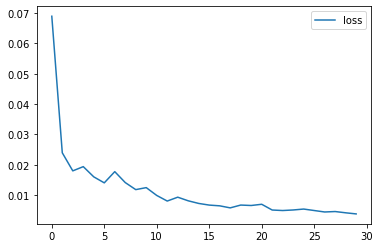

In [ ]:
# load the loss data (model.history.history) into a dataframe
df_model_loss = pd.DataFrame(model.history.history)

# Visualize the loss data using the DataFrame.plot()
df_model_loss.plot()

# Prediction for Testing: Using Timeseries Generator

## Create Timeseries Generator for Testing

In [ ]:
# batch_size MUST be 1
batch_size1 = 1

# create a TimeseriesGenerator for testing: test_tsGenerator
test_tsGenerator36 = TimeseriesGenerator(normalized_test, normalized_test, length = length36, batch_size = batch_size1)

## Predict Future Data Points for Testing

In [ ]:
normalized_prediction = model.predict_generator(test_tsGenerator36)

In [ ]:
# prediction is a 2D numpy array with only one column
normalized_prediction

array([[0.42143598],
       [0.4142121 ],
       [0.40554592],
       [0.3972194 ],
       [0.38854393],
       [0.38130268],
       [0.3744449 ],
       [0.36731306],
       [0.36046633],
       [0.3565484 ],
       [0.35316512],
       [0.34890977],
       [0.3430349 ],
       [0.33534423],
       [0.32693282],
       [0.31994334],
       [0.31439355],
       [0.30863976],
       [0.30357683],
       [0.3005972 ],
       [0.30079195],
       [0.301094  ],
       [0.30141327],
       [0.30078337],
       [0.30010054],
       [0.30060467],
       [0.30149898],
       [0.30061153],
       [0.29777494],
       [0.2936224 ],
       [0.28816167],
       [0.2804676 ],
       [0.27139714],
       [0.2622765 ],
       [0.25339884],
       [0.24548952],
       [0.23991284],
       [0.23617262],
       [0.2331723 ],
       [0.23062807],
       [0.22774401],
       [0.2238263 ],
       [0.2199686 ],
       [0.21605639],
       [0.2123751 ],
       [0.20780401],
       [0.20391728],
       [0.199

In [ ]:
len(normalized_prediction)

89

In [ ]:
# Convert normalized predictions back to true values
prediction = scaler.inverse_transform(normalized_prediction)

In [ ]:
# Flatten the 2D array

prediction_index = np.arange(800, 889, step = 1)

df_prediction = pd.DataFrame(data = prediction, index = prediction_index, columns = ['Prediction'])

In [ ]:
df_prediction

,Prediction
800,5.997919
801,5.937960
802,5.866031
803,5.796921
804,5.724915
...,...
884,5.068731
885,4.992763
886,4.903791
887,4.785556


## Visualize Predictions

<AxesSubplot:>

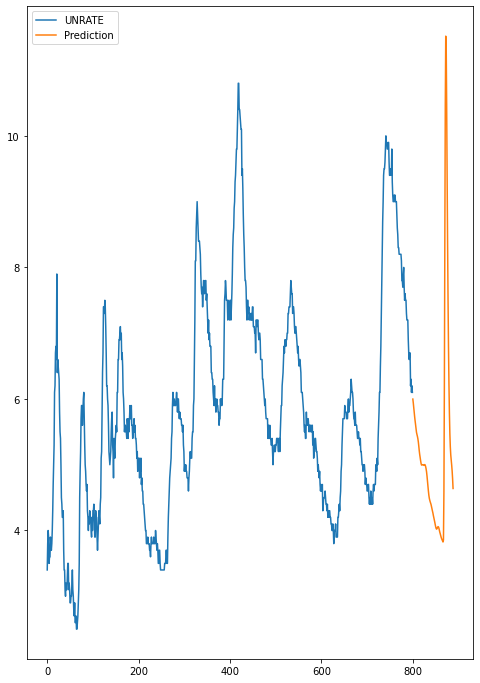

In [ ]:
ax = data_train.plot()

df_prediction.plot(ax = ax, figsize = (8,12))

## Visualize Predictions and Compare Against Actual Unemployment Rate

<AxesSubplot:>

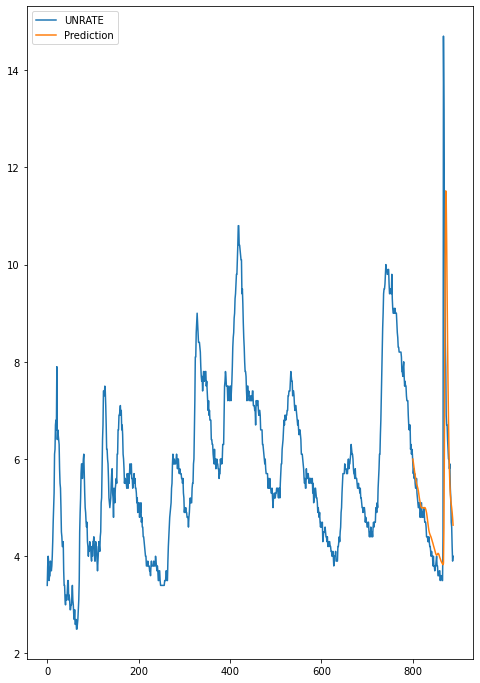

In [ ]:
ax = df.plot()
df_prediction.plot(ax = ax, figsize = (8,12))

# Timeseries Forecasting with LSTM

## Overview:
### Timeseries Forecasting:
### --) Forecast into the "future" or unknown range¶
### --) Should employ all of the available data
### --) i.e., NOT split the data into training/testing sets

## Preprocess Full Input Dataset

In [ ]:
# Still use the MinMaxScaler to normalize the full input dataset df

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

## Create Timeseries Generator for Forecasting

In [ ]:
# Number of time steps of the input time series
# still use length36
length36

36

In [ ]:
# Create timeseries Generator for forecasting
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length = length36, batch_size = batch_size15)

## Build, Compile, Fit LSTM Model for Forecasting

In [ ]:
# Train/Fit the LSTM model
# In forecasting, we don't validate

model.fit_generator(forecast_tsGenerator, epochs = 30)

Epoch 1/30
57/57 [==============================] - 11s 186ms/step - loss: 0.0043
Epoch 2/30
57/57 [==============================] - 10s 184ms/step - loss: 0.0042
Epoch 3/30
57/57 [==============================] - 10s 183ms/step - loss: 0.0041
Epoch 4/30
57/57 [==============================] - 10s 181ms/step - loss: 0.0038
Epoch 5/30
57/57 [==============================] - 10s 181ms/step - loss: 0.0039
Epoch 6/30
57/57 [==============================] - 10s 183ms/step - loss: 0.0042
Epoch 7/30
57/57 [==============================] - 10s 182ms/step - loss: 0.0037
Epoch 8/30
57/57 [==============================] - 10s 183ms/step - loss: 0.0037
Epoch 9/30
57/57 [==============================] - 11s 184ms/step - loss: 0.0039
Epoch 10/30
57/57 [==============================] - 11s 186ms/step - loss: 0.0039
Epoch 11/30
57/57 [==============================] - 11s 186ms/step - loss: 0.0037
Epoch 12/30
57/57 [==============================] - 11s 186ms/step - loss: 0.0035
Epoch 13/30
5

# Timeseries Forecast with LSTM Neural Network: 02/01/2022 - 02/01/2026

In [ ]:
forecast = []

# Set periods with the time span of forecasting 
# Let's forecast for the next 48 data points = 4 years (02/01/2022 - 02/01/2026)
periods = 48

first_eval_batch = normalized_full_data[-length36: ]
current_batch = first_eval_batch.reshape((1, length36, n_features))

for i in range(periods):
    # Get prediction 1 time stamp ahead ([0] is for grabbing just the # instead of whole array)
    current_pred = model.predict(current_batch)[0]
    
    # Store prediction
    forecast.append(current_pred)
    
    # Update batch to now include prediction and drop the first value
    current_batch = np.append(current_batch[ : , 1: , : ], [[current_pred]], axis = 1)

## Inverse to Transform Normalized Data Back into True Values

In [ ]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[4.37257372],
       [4.25224271],
       [4.23008036],
       [4.27626135],
       [4.36517452],
       [4.48298023],
       [4.62248107],
       [4.77841829],
       [4.94687058],
       [5.12341617],
       [5.30102853],
       [5.47413839],
       [5.63766806],
       [5.78686471],
       [5.91772161],
       [6.02715588],
       [6.11647571],
       [6.18392571],
       [6.22691858],
       [6.24448062],
       [6.23722267],
       [6.20654818],
       [6.15478483],
       [6.08502532],
       [6.00097533],
       [5.90665979],
       [5.80628251],
       [5.7039473 ],
       [5.60356638],
       [5.50864655],
       [5.42223651],
       [5.34683666],
       [5.28472522],
       [5.2373373 ],
       [5.20545897],
       [5.18933637],
       [5.18870155],
       [5.20283241],
       [5.23061237],
       [5.27055619],
       [5.32087972],
       [5.3795547 ],
       [5.44437541],
       [5.51300616],
       [5.58305709],
       [5.65214105],
       [5.71799381],
       [5.778

In [ ]:
df

,UNRATE
0,3.4
1,3.8
2,4.0
3,3.9
4,3.5
...,...
884,4.7
885,4.6
886,4.2
887,3.9


## Creating New Timestamp Index with Pandas - 02/01/2022 - 02/01/2026

In [ ]:
# Calculate forecast index 
forecast_index = np.arange(889, 937, step = 1)

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
889,4.372574
890,4.252243
891,4.230080
892,4.276261
893,4.365175
894,4.482980
895,4.622481
896,4.778418
897,4.946871
898,5.123416


## Plot the Forecast

<AxesSubplot:>

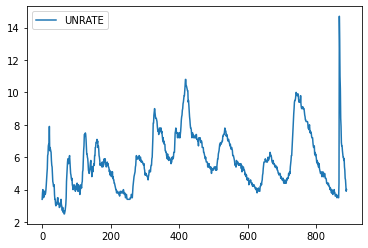

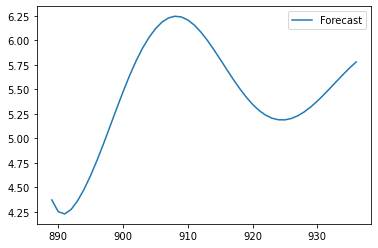

In [ ]:
df.plot()
forecast_df.plot()

## Joining Pandas Plots

<AxesSubplot:>

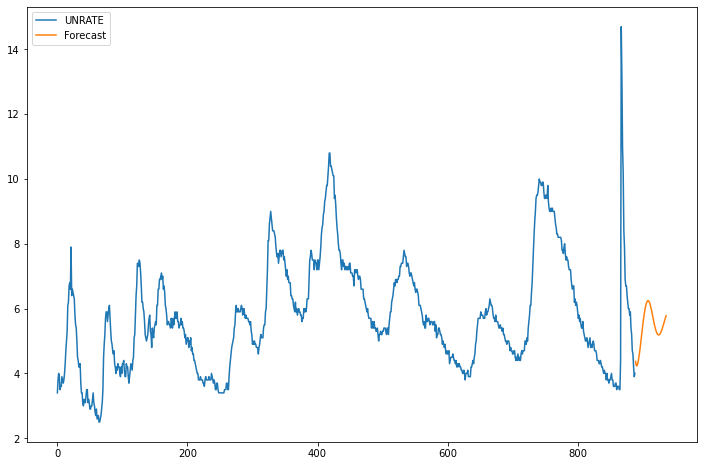

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (12,8))